In [9]:
# handle warnings
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import numpy as np
import pandas as pd

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    fbeta_score,
    precision_score, 
    recall_score,
    classification_report
)
from sklearn.metrics import precision_recall_curve, classification_report

# Deep learning
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

# Visualization
import matplotlib.pyplot as plt

# Data loading
import kagglehub
import os

# Introduction

In this notebook, we will use TabNet to detect credit card fraud.

TabNet is a deep learning model that is interpretable. Unlike traditional deep learning models, TabNet uses sequential attention to choose which features to reason from at each decision step, enabling interpretability and more efficient learning as the learning capacity is used for the most salient features. (Read the the original [TabNet paper](https://arxiv.org/abs/1908.07442))

We will use the credit card fraud dataset from Kaggle (more details in project ReadMe). 


In [10]:
# Download latest version of the credit card fraud dataset
folder_path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
file_path = os.path.join(folder_path, "creditcard.csv")

# Read the CSV
df = pd.read_csv(file_path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
# Prepare the data
X = df.drop(['Class'], axis=1)
y = df['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize TabNet
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax',
    lambda_sparse=1e-3
)

# Train the model
clf.fit(
    X_train=X_train.values, y_train=y_train.values,
    eval_set=[(X_test.values, y_test.values)],
    max_epochs=100,
    patience=5,
    batch_size=1024,
    virtual_batch_size=128,
    eval_metric=['auc']
)

epoch 0  | loss: 0.03182 | val_0_auc: 0.9201  |  0:00:12s
epoch 1  | loss: 0.00665 | val_0_auc: 0.9295  |  0:00:23s
epoch 2  | loss: 0.00531 | val_0_auc: 0.93975 |  0:00:35s
epoch 3  | loss: 0.0049  | val_0_auc: 0.95222 |  0:00:47s
epoch 4  | loss: 0.00467 | val_0_auc: 0.95734 |  0:01:00s
epoch 5  | loss: 0.00443 | val_0_auc: 0.9612  |  0:01:12s
epoch 6  | loss: 0.00446 | val_0_auc: 0.95446 |  0:01:24s
epoch 7  | loss: 0.00449 | val_0_auc: 0.97556 |  0:01:36s
epoch 8  | loss: 0.00422 | val_0_auc: 0.96572 |  0:01:48s
epoch 9  | loss: 0.00414 | val_0_auc: 0.97481 |  0:02:00s
epoch 10 | loss: 0.00413 | val_0_auc: 0.969   |  0:02:13s
epoch 11 | loss: 0.00402 | val_0_auc: 0.94737 |  0:02:26s
epoch 12 | loss: 0.00394 | val_0_auc: 0.96219 |  0:02:38s

Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_auc = 0.97556


# Find the optimal threshold

For credit card fraud detection, the cost of a false positive (i.e., a customer being requested to verify their account before a transaction is approved) is much lower than the cost of a false negative (i.e., a fraud case being missed). Therefore, in the trade-off between precision and recall, we should prioritize recall. In the code below, we will use F-beta score with beta = 2, which means we give recall twice the weight of precision to boost recall while not penalizing precision too much.


At optimal threshold 0.092:
Precision: 0.762
Recall: 0.786
F-2 Score: 0.781


{'threshold': np.float32(0.092377566),
 'precision': np.float64(0.7623762376237624),
 'recall': np.float64(0.7857142857142857),
 'f_beta': np.float64(0.7809330628803246),
 'beta': 2}

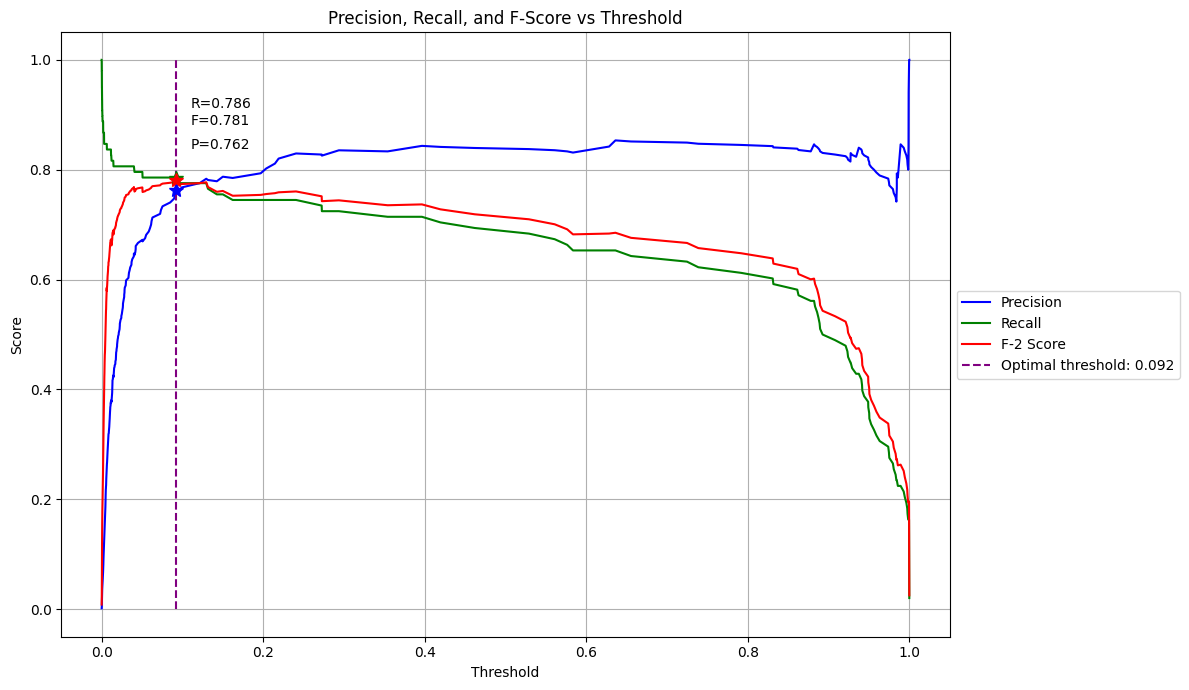

In [21]:
# Get predicted probabilities for the positive class
y_pred_proba = clf.predict_proba(X_test.values)[:, 1]

import ml_utils as mlu
mlu.optimize_threshold(y_test, y_pred_proba, beta=2)

In [13]:
# Compare with default threshold (0.5)
y_pred_default = (y_pred_proba >= 0.5).astype(int)
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

print("With default threshold (0.5):")
print(classification_report(y_test, y_pred_default))

print("\nWith optimal threshold (0.092):")
print(classification_report(y_test, y_pred_optimal))

With default threshold (0.5):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.68      0.75        98

    accuracy                           1.00     56962
   macro avg       0.92      0.84      0.88     56962
weighted avg       1.00      1.00      1.00     56962


With optimal threshold (0.092):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.79      0.77        98

    accuracy                           1.00     56962
   macro avg       0.88      0.89      0.89     56962
weighted avg       1.00      1.00      1.00     56962



# TabNet Interpretability

One fascinating property of TabNet is its interpretability. TabNet is interpretable because:
1. Sequential Attention:
* Makes decisions step by step
* Each step focuses on different features
* You can see which features matter at each step
2. Sparse Feature Selection:
* Uses mask mechanism to select important features
* Explicitly shows which features it uses
* Similar to how humans make decisions
3. Instance-wise Explanations:
* Can explain each prediction individually
* Shows which features were important for specific cases
* Unlike global importance in random forests


## Global Feature Importance


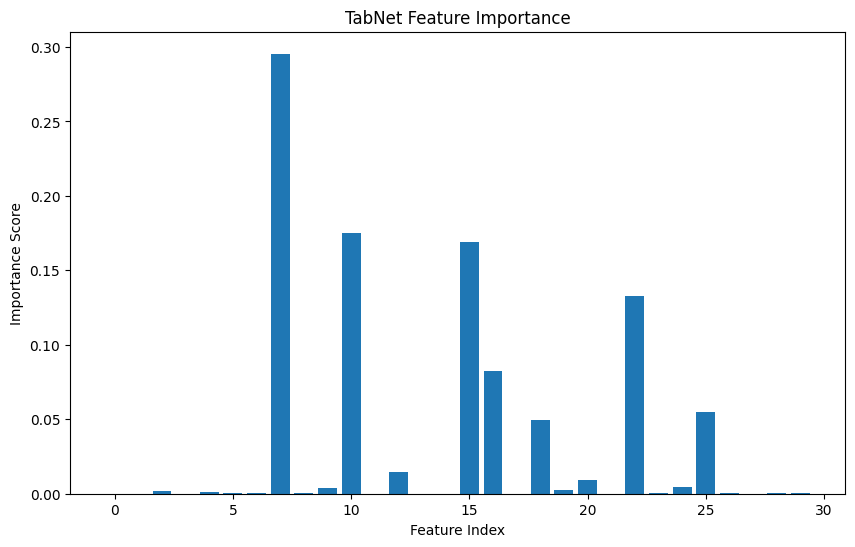

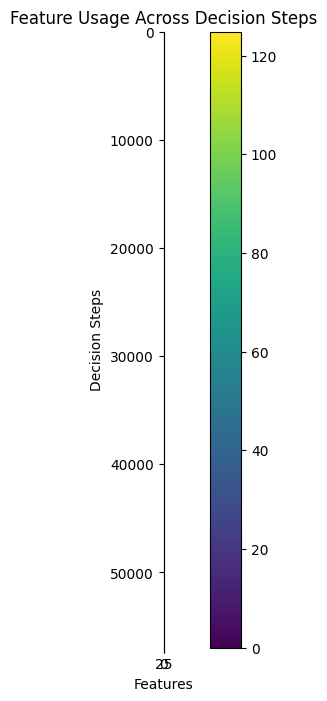

In [14]:
# Get feature importance
feature_importance = clf.feature_importances_

# Get feature masks for specific decisions
masks = clf.explain(X_test.values)

# Visualize overall importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.title('TabNet Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.show()

# Visualize decision-specific masks
plt.figure(figsize=(12, 8))
plt.imshow(masks[0])  # First sample
plt.title('Feature Usage Across Decision Steps')
plt.xlabel('Features')
plt.ylabel('Decision Steps')
plt.colorbar()
plt.show()

## Explain individual predictions

True Label: Fraud
Predicted Label: Fraud
Fraud Probability: 0.832


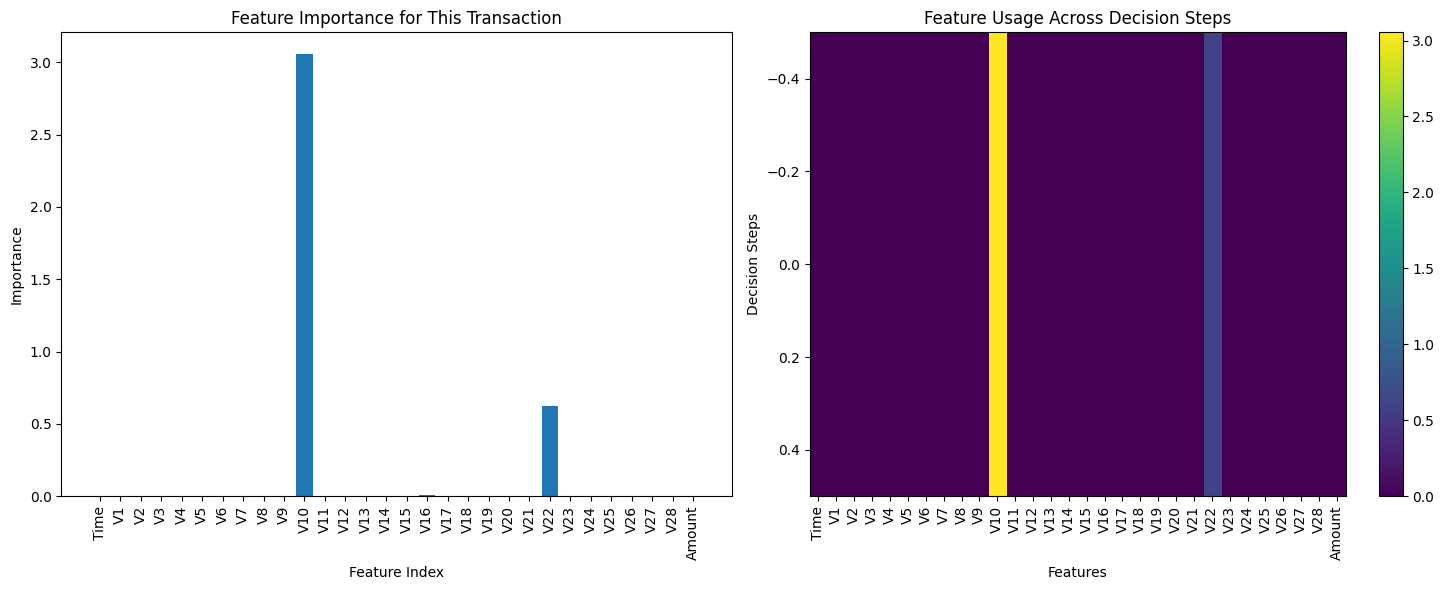


Top 5 Most Important Features for this Decision:
Feature V10: 3.054
Feature V22: 0.621
Feature V16: 0.006
Feature V27: 0.000
Feature Amount: 0.000

Feature Values Comparison:

Feature V10:
  Value: -2.999
  Average: -0.001
  Z-score: -2.759

Feature V22:
  Value: -0.466
  Average: -0.001
  Z-score: -0.641

Feature V16:
  Value: -4.180
  Average: 0.001
  Z-score: -4.765

Feature V27:
  Value: -0.631
  Average: -0.000
  Z-score: -1.570

Feature Amount:
  Value: 311.280
  Average: 88.480
  Z-score: 0.874


In [27]:
# Pick a fraud case from test set
fraud_indices = np.where(y_test == 1)[0]
n = 2 # pick the nth fraud case
sample_idx = fraud_indices[n-1] 

# Get the sample data
sample = X_test.values[sample_idx:sample_idx+1]
true_label = y_test.iloc[sample_idx]

# Get prediction and probability for this case
pred = clf.predict(sample)
pred_proba = clf.predict_proba(sample)

# Get instance-wise feature importance
masks = clf.explain(sample)

# Print basic information
print(f"True Label: {'Fraud' if true_label == 1 else 'Normal'}")
print(f"Predicted Label: {'Fraud' if pred[0] == 1 else 'Normal'}")
print(f"Fraud Probability: {pred_proba[0][1]:.3f}")

# Get feature names from X_train
feature_names = X_train.columns.tolist()

# Convert X_train to numpy if it's not already
X_train_np = X_train.values if hasattr(X_train, 'values') else X_train

# Visualize feature importance for this instance
plt.figure(figsize=(15, 6))

# Plot 1: Overall feature importance for this instance
plt.subplot(1, 2, 1)
instance_importance = masks[0].sum(axis=0)  # Sum across decision steps
plt.bar(range(len(instance_importance)), instance_importance)
plt.title('Feature Importance for This Transaction')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.xticks(range(len(feature_names)), feature_names, rotation=90)

# Plot 2: Feature usage across decision steps
plt.subplot(1, 2, 2)
plt.imshow(masks[0], aspect='auto')
plt.title('Feature Usage Across Decision Steps')
plt.xlabel('Features')
plt.ylabel('Decision Steps')
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.colorbar()

plt.tight_layout()
plt.show()

# Print top 5 most important features for this decision
top_features = np.argsort(instance_importance)[-5:][::-1]
print("\nTop 5 Most Important Features for this Decision:")
for idx in top_features:
    print(f"Feature {feature_names[idx]}: {instance_importance[idx]:.3f}")

# Compare feature values with average values
print("\nFeature Values Comparison:")
for idx in top_features:
    feature_name = feature_names[idx]
    sample_value = sample[0][idx]
    avg_value = X_train_np[:, idx].mean()
    std_value = X_train_np[:, idx].std()
    z_score = (sample_value - avg_value) / std_value
    
    print(f"\nFeature {feature_name}:")
    print(f"  Value: {sample_value:.3f}")
    print(f"  Average: {avg_value:.3f}")
    print(f"  Z-score: {z_score:.3f}")

# Troubleshooting

* False negative that the model is confident about: e.g. The 5th fraud case above.
 